## SIFT - scale inavriant feature transform
from Lowe, David G. "Distinctive image features from scale-invariant keypoints." International journal of computer vision 60.2 (2004): 91-110.

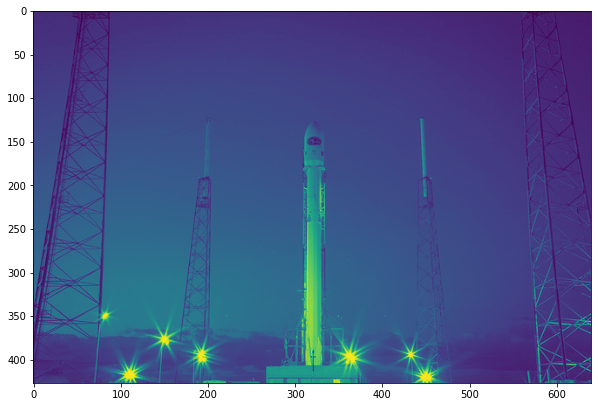

In [56]:
from  skimage import data
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
img_orig = data.rocket()
img  = rgb2gray(img_orig)
plt.figure(figsize=(10,10))
plt.imshow(img)

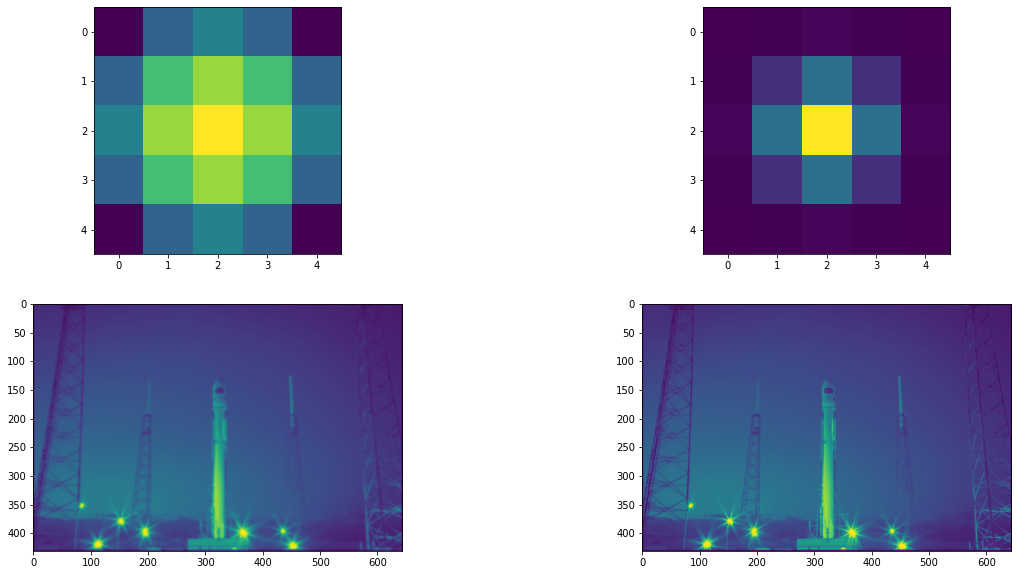

In [57]:
import numpy as np
from scipy import signal

sigmas = [np.sqrt(2)/2,  1, np.sqrt(2), 2, 2*np.sqrt(2)]

kernel_1 = np.outer(signal.gaussian(5, sigmas[4]), signal.gaussian(5, sigmas[4]))
kernel_1 = kernel_1 / np.sum(kernel_1)

kernel_2 = np.outer(signal.gaussian(5, sigmas[0]), signal.gaussian(5, sigmas[0]))
kernel_2 = kernel_2 / np.sum(kernel_2)

gauss_filt_img = signal.convolve2d(img,kernel_1)
gauss_filt_img_2 = signal.convolve2d(img,kernel_2)

plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(kernel_1)
plt.subplot(222)
plt.imshow(kernel_2)
plt.subplot(223)
plt.imshow(gauss_filt_img)
plt.subplot(224)
plt.imshow(gauss_filt_img_2)

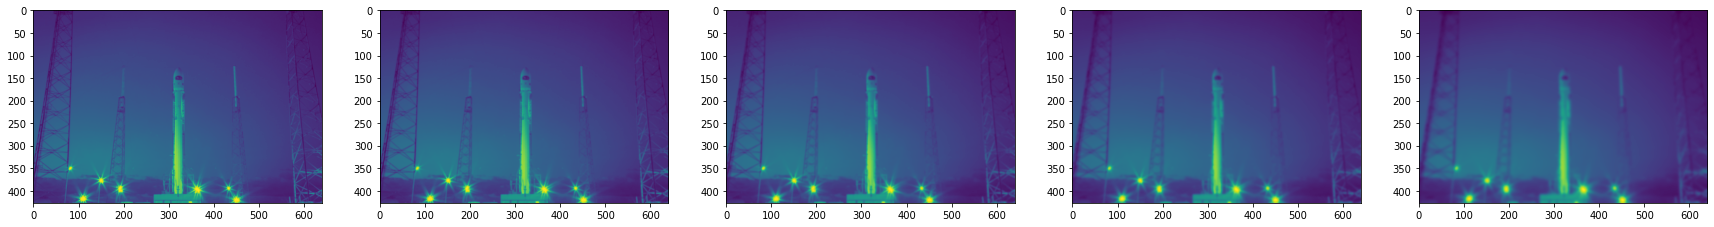

In [58]:
from scipy.ndimage import gaussian_filter
imgs_blured  = np.zeros(shape=(img.shape[0], img.shape[1], 5))

for i, sigma in zip(range(len(sigmas)),sigmas):
    imgs_blured[:,:, i]  = gaussian_filter(img,sigma)

fig, axs = plt.subplots(1, 5,figsize=(30,10))
for i in range(len(sigmas)):
    axs[i].imshow(imgs_blured[:,:,i])

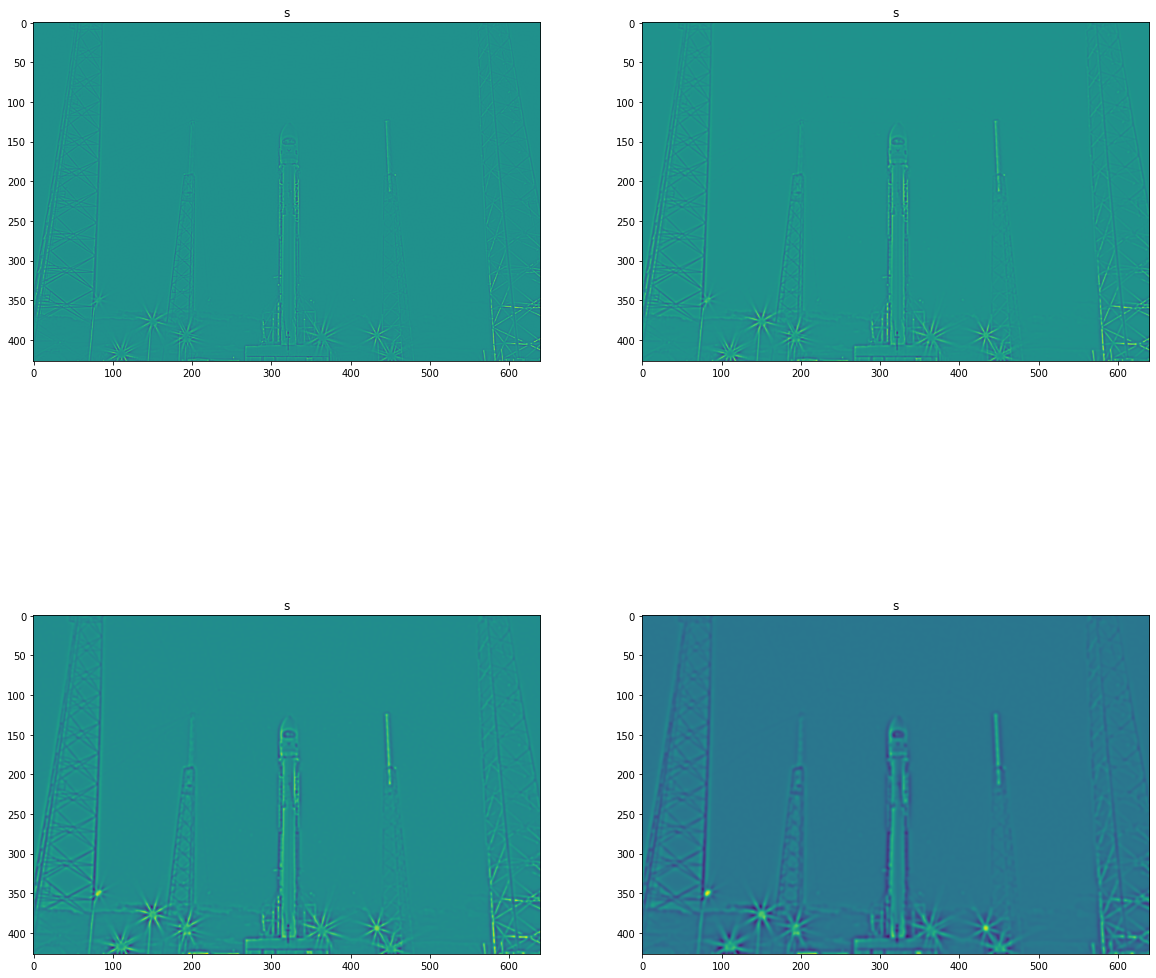

In [59]:
difference_of_gaussians = np.zeros(shape=(img.shape[0], img.shape[1], 4))

for i in range(len(sigmas)-1):
    difference_of_gaussians[:,:,i] = imgs_blured[:,:,i]-imgs_blured[:,:,i+1]

fig, axs = plt.subplots(2, 2,figsize=(20,20))
for i in range(len(sigmas)-1):
    axs[i // 2,i % 2].imshow(difference_of_gaussians[:,:,i])
    axs[i // 2,i % 2].set_title("s")

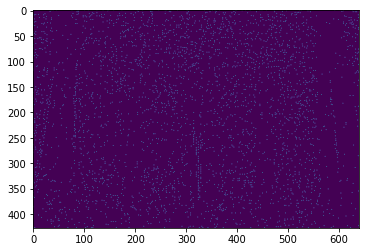

In [60]:
from scipy.ndimage import maximum_filter,minimum_filter

dog_max_filt = maximum_filter(difference_of_gaussians,(3,3,3))
dog_min_filt = minimum_filter(difference_of_gaussians,(3,3,3))

local_max = (difference_of_gaussians==dog_max_filt)
local_min = (difference_of_gaussians==dog_min_filt)
keypoints = np.logical_or(np.sum(local_max[:,:,1:2],axis=2)>0, np.sum(local_min[:,:,1:2],axis=2)>0)

plt.imshow(keypoints)

<Figure size 720x720 with 0 Axes>

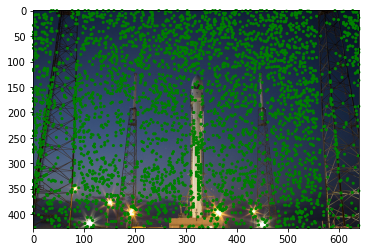

In [61]:
plt.figure(figsize=(10,10))
fig, ax = plt.subplots() #

rr, cc = np.where(keypoints)
ax.imshow(img_orig)
for r,c in zip(rr,cc):
    circle1 = plt.Circle((c, r), 2, color='g', clip_on=False)
    ax.add_patch(circle1)

In [62]:
from skimage import transform

def return_dog_extremas(img, im_scale):
    img_rescaled = transform.rescale(img,im_scale)

    sigmas = [1,  2, 4, 8, 16]
    imgs_blured  = np.zeros(shape=(img_rescaled.shape[0], img_rescaled.shape[1], 5))

    for i, sigma in zip(range(len(sigmas)),sigmas):
        imgs_blured[:,:, i]  = gaussian_filter(img_rescaled,sigma)

    difference_of_gaussians = np.zeros(shape=(img_rescaled.shape[0], img_rescaled.shape[1], 4))

    for i in range(len(sigmas)-1):
        difference_of_gaussians[:,:,i] = imgs_blured[:,:,i]-imgs_blured[:,:,i+1]
    dog_max_filt = maximum_filter(difference_of_gaussians,(3,3,3))
    dog_min_filt = minimum_filter(difference_of_gaussians,(3,3,3))

    local_max = (difference_of_gaussians==dog_max_filt)
    local_min = (difference_of_gaussians==dog_min_filt)

    key_points_candidates = np.logical_or(np.sum(local_max[:,:,1:2],axis=2)>0, np.sum(local_min[:,:,1:2],axis=2)>0)

    return transform.resize(key_points_candidates, output_shape=(img.shape[0],img.shape[1]))

Working at scale: 2
Working at scale: 1
Working at scale: 0.5


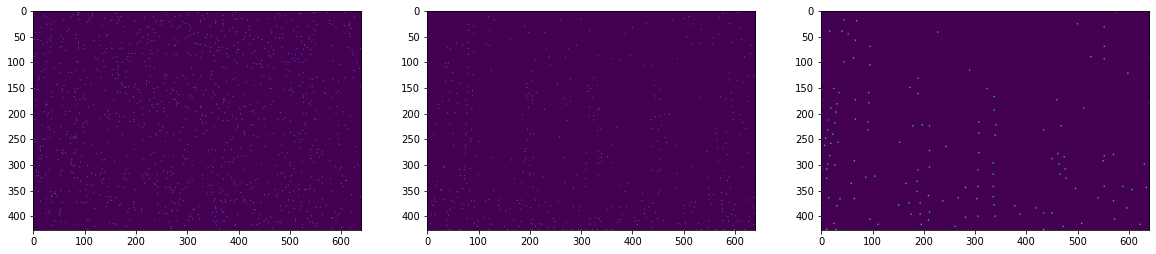

In [63]:
scales = (2,1,.5,)

local_extremas_at_different_scales = np.zeros(shape=(img.shape[0], img.shape[1], len(scales)))

octave = return_dog_extremas(img,scales[2])

fig, axs = plt.subplots(1, len(scales),figsize=(20,20))
for i in range(len(scales)):
    print("Working at scale: {}".format(scales[i]))
    local_extremas_at_different_scales[:,:,i] = return_dog_extremas(img, scales[i])
    axs[i].imshow(return_dog_extremas(img,scales[i]))

Detected keypoints candidates: 2133


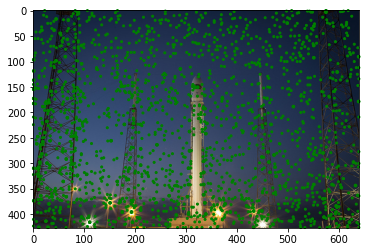

In [64]:
fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
rr, cc = np.where(np.sum(local_extremas_at_different_scales,axis=2)>0)
ax.imshow(img_orig)
for r,c in zip(rr,cc):
    circle1 = plt.Circle((c, r), 2, color='g', clip_on=False)
    ax.add_patch(circle1)
print("Detected keypoints candidates:", np.sum(np.sum(local_extremas_at_different_scales,axis=2)>0))